In [2]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
 
img = cv.imread('periodic_noise.jpg', cv.IMREAD_GRAYSCALE)

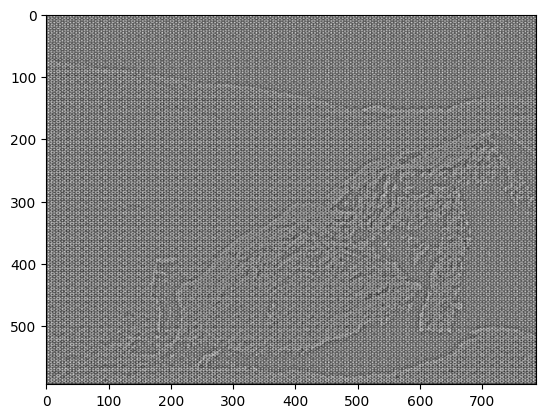

In [3]:
sigma=4.0

kernel_size=None
    
if kernel_size is None:
        kernel_size = int(6 * sigma) + 1
        if kernel_size % 2 == 0:
            kernel_size += 1
    
gaussian_kernel = cv.getGaussianKernel(kernel_size, sigma)
gaussian_kernel_2d = gaussian_kernel * gaussian_kernel.T
    
low_pass = cv.filter2D(img, -1, gaussian_kernel_2d)
    
high_pass = img.astype(np.float32) - low_pass.astype(np.float32)
    
high_pass_normalized = cv.normalize(high_pass, None, 0, 255, cv.NORM_MINMAX)
high_pass_uint8 = np.uint8(high_pass_normalized)

plt.imshow(high_pass_uint8, cmap='gray')

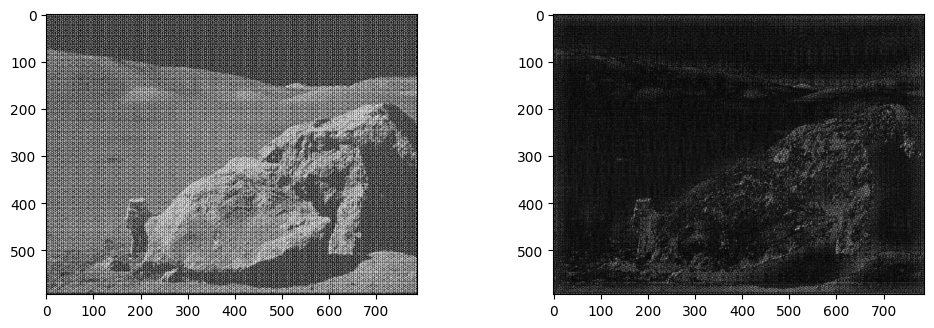

In [13]:
from skimage.feature import peak_local_max

dft = cv.dft(np.float32(img), flags=cv.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

rows, cols = img.shape
#magnitude = cv.magnitude(dft_shift[:,:,0], dft_shift[:,:,1])
center_x, center_y = rows//2, cols//2

magnitude_actual = cv.magnitude(dft_shift[:,:,0], dft_shift[:,:,1])

# Находим пики на реальной величине (не логарифмированной)
local_maxima = peak_local_max(magnitude_actual, min_distance=20, threshold_abs=180)

# Создаем маску
mask = np.ones((rows, cols, 2), dtype=np.float32)
for y, x in local_maxima:
    # Проверяем что это не центральная компонента
    if np.sqrt((x - center_x)**2 + (y - center_y)**2) > 40:
        cv.circle(mask, (x, y), 5, (0, 0), -1)
        # Также удаляем симметричную точку (важно для вещественных изображений)
        

filtered_dft = dft_shift * mask
dft_ishift = np.fft.ifftshift(filtered_dft)
img_back = cv.idft(dft_ishift)
img_back = cv.magnitude(img_back[:,:,0], img_back[:,:,1])
    
filtered1 = cv.normalize(img_back, None, 0, 255, cv.NORM_MINMAX).astype(np.uint8)
    
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.imshow(img, cmap='gray')

plt.subplot(2, 2, 2)
plt.imshow(img_back, cmap='gray')
